In [1]:
# project: p6
# submitter: xhuang438
# partner: none
# hours: 8

In [2]:
import geopandas as gpd
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.mask import mask
import rasterio

In [3]:
#Q1
file_path = 'counties.geojson'
counties = gpd.read_file(file_path)
counties['NAME'].nunique()

72

<AxesSubplot:>

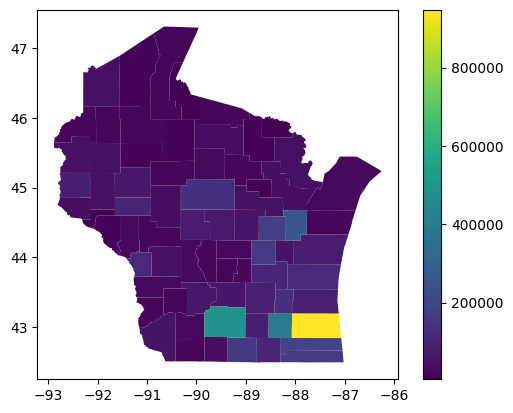

In [4]:
#Q2
counties.plot("POP100",legend = True)

In [5]:
conn = sqlite3.connect('counties_tracts.db')
AREALAND = pd.read_sql("""SELECT * FROM counties""", conn).groupby("NAME")["AREALAND"].sum()
counties = counties.merge(AREALAND, on="NAME", how='left')
train, test = train_test_split(counties, test_size=0.25, random_state=250)

In [6]:
#Q3
test["NAME"].to_list()

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [7]:
#Q4
reg = LinearRegression().fit(train["AREALAND"].values.reshape(-1, 1),train["POP100"])
reg.score(test["AREALAND"].values.reshape(-1, 1), test["POP100"])

0.016720430179409274

In [8]:
#Q5
reshaped = 400 * 2590000
float(reg.predict(np.array([reshaped]).reshape(-1, 1)))

/tmp/ipykernel_2618896/681335863.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(reg.predict(np.array([reshaped]).reshape(-1, 1)))


90000.07422783462

In [9]:
HU100 = pd.read_sql("""SELECT SUM(tracts.HU100) as HU100, counties.NAME FROM tracts LEFT JOIN counties ON tracts.COUNTY = counties.COUNTY GROUP BY counties.NAME""", conn)
counties = counties.merge(HU100, on="NAME", how='left')
train, test = train_test_split(counties, test_size=0.25, random_state=250)

In [10]:
#Q6
test["NAME"].to_list()

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [11]:
#Q7
pd.Series(test.HU100.values,index=test.NAME).to_dict()

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [12]:
#Q8
arr = cross_val_score(LinearRegression(),train["HU100"].values.reshape(-1, 1),train["POP100"],cv=5)
result = 0
for i in range(5):
    result += arr[i]
result / len(arr)

0.9739348181232653

In [13]:
#Q9
np.std(arr)

0.01693954236334351

In [14]:
#Q10
reg = LinearRegression().fit(train["HU100"].values.reshape(-1, 1),train["POP100"])
"POP100 = %s*HU100 + %s" % (str(round(float(reg.coef_), 2)), str(round(reg.intercept_,2)))

/tmp/ipykernel_2618896/2629846943.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "POP100 = %s*HU100 + %s" % (str(round(float(reg.coef_), 2)), str(round(reg.intercept_,2)))


'POP100 = 2.47*HU100 + -9276.89'

/tmp/ipykernel_2618896/1905696933.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.linspace(min(counties["HU100"]), max(counties["HU100"])), float(reg.coef_) * np.linspace(min(counties["HU100"]), max(counties["HU100"])) + reg.intercept_, c="red", label = "Predicted")


Text(109371, 223007, 'Brown')

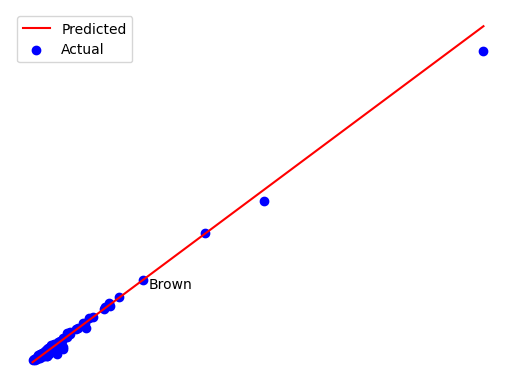

In [15]:
#Q11
plt.plot(np.linspace(min(counties["HU100"]), max(counties["HU100"])), float(reg.coef_) * np.linspace(min(counties["HU100"]), max(counties["HU100"])) + reg.intercept_, c="red", label = "Predicted")
plt.scatter(counties["HU100"], counties["POP100"], c="blue", label = "Actual")
plt.legend(loc="upper left")
plt.axis('off')
offset = 5000
plt.text(int(counties[counties['NAME'] == 'Brown County']['HU100']) + offset,int(counties[counties['NAME'] == 'Brown County']['POP100']) - 5*offset,"Brown") 

In [16]:
#Q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
np.sum((A >= 3) & (A <= 6))

8

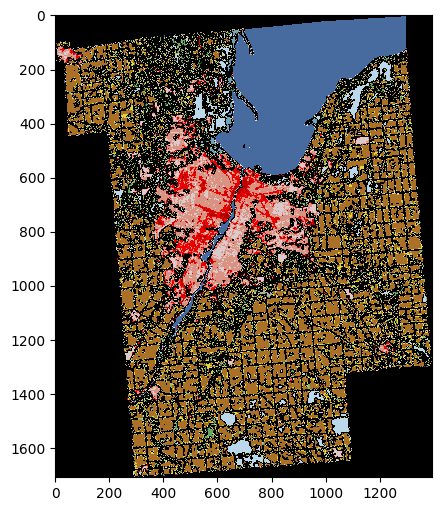

In [17]:
#Q13
fig, ax = plt.subplots(figsize=(6,6))

land = rasterio.open("zip://../p6/land.zip!wi.tif")
brown = counties[counties['NAME'] == 'Brown County']
matrix, _ = mask(land, brown.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)
plt.imshow(matrix, vmin=0, vmax=255, cmap = custom_cmap)

In [18]:
#Q14
np.sum(matrix == 11) / np.sum(matrix != 0)

0.13797526789725206

Text(0, 0.5, 'POP')

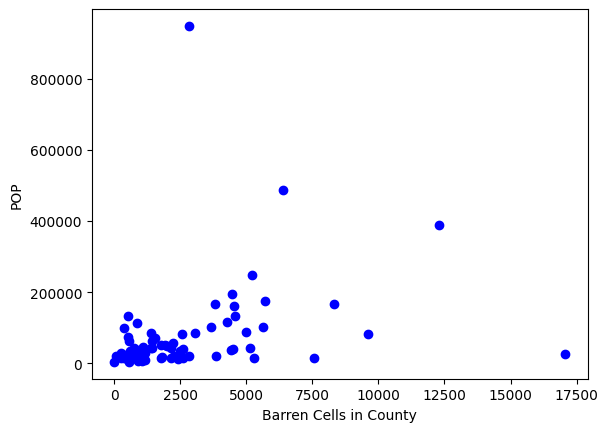

In [19]:
#Q15
county_arr = []
barren_arr = []
data = {}
for index, row in counties.iterrows():
    county = counties[counties['NAME'] == row['NAME']]
    matrix, _ = mask(land, county.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    county_arr.append(row['NAME'])
    barren_arr.append(np.sum(matrix == 31))
data['NAME'] = county_arr
data['BARREN'] = barren_arr
data['POP100'] = counties['POP100'].tolist()
df = pd.DataFrame(data)
plt.scatter(df["BARREN"], counties["POP100"], c="blue")
plt.xlabel("Barren Cells in County")
plt.ylabel("POP")

<BarContainer object of 20 artists>

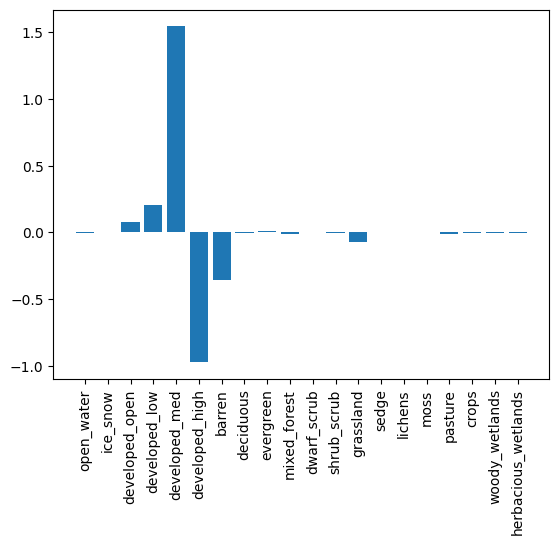

In [20]:
tracts = gpd.read_file('tracts.shp')
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}      
for i in tracts.index:
    geoID = tracts.iloc[i:i+1]
    matrix, _ = mask(land, geoID.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    for j in land_use:
        tracts.loc[i,j] = np.sum(matrix == land_use[j])
train, test = train_test_split(tracts, test_size=0.20, random_state=300)
features = list(train.columns[3:])
reg = LinearRegression().fit(train[features],train["POP100"])
plt.xticks(rotation=90)
plt.bar(features, reg.coef_)
# The graph shows features, excluding developed_open, developed_low, developed_med, developed_high, barren, and grassland, have a coefficient close to 0,
# It means they have tiny effect on POP100. When I am building the model, I may consider dropping those features.

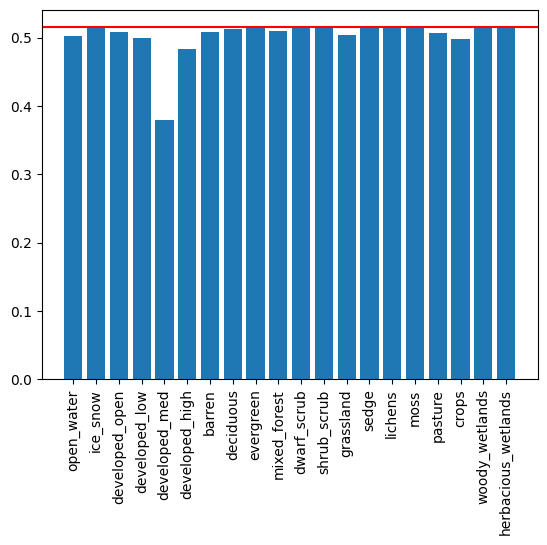

In [21]:
#Q16
scores = []
x = train[features]
y = train["POP100"]
score = reg.score(x,y)
for col in x:
    xi = x.drop(col, axis = 1)
    reg.fit(xi, y)
    scores.append(reg.score(xi, y))
plt.xticks(rotation=90)
plt.bar(features, scores)
plt.axhline(y=score, color='r', linestyle='-')
# It is apparent now removing ice_snow, deciduous, evergreen, dwarf_scrub, shrub_scrub, sedge, lichens, moss, woody_wetlands, herbacious_wetlands has
# almost no effect on our score. It means in the model we can probably train while dropping those features

<ErrorbarContainer object of 3 artists>

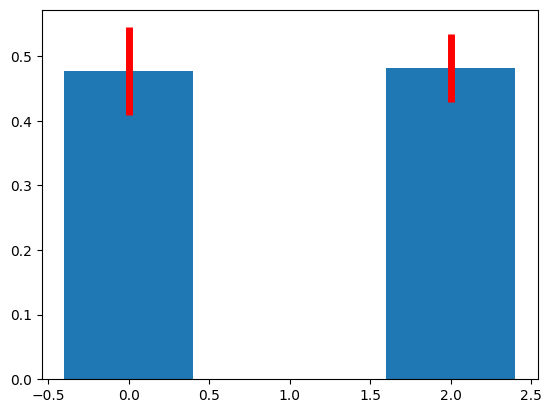

In [22]:
# Regression Model 1
all_features = cross_val_score(LinearRegression(),tracts.iloc[:,3:],tracts["POP100"],cv=10)

# Regression Model 2
tracts_revised = tracts.drop(['ice_snow','evergreen','dwarf_scrub','shrub_scrub','sedge','deciduous',
                              'lichens','moss','woody_wetlands','herbacious_wetlands'],axis = 1)
subset_features = cross_val_score(LinearRegression(),tracts_revised.iloc[:,3:],tracts_revised["POP100"],cv=10)

fig, ax = plt.subplots()
ax.bar([0, 2], [all_features.mean(), subset_features.mean()])
ax.errorbar([0, 2], [all_features.mean(), subset_features.mean()], yerr = [all_features.std(), subset_features.std()], elinewidth = 5, color = "red", linestyle='none')
# (a) mean of cv scores is higher for Regression Model 2
# (b) Variance of cv scores is lower for Regression Model 2
# So I recommend Regression Model 2

In [23]:
train, test = train_test_split(tracts_revised, test_size=0.20, random_state=300)
feature_train = list(train.columns[3:])
reg = LinearRegression().fit(train[feature_train],train["POP100"])
feature_test = list(test.columns[3:])
score = reg.score(test[feature_test], test["POP100"])

In [24]:
#Q17
score

0.47275114493968706